In [1]:
from osgeo import gdal, ogr, osr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from pyproj import Proj
import affine

In [10]:
# Avoid bands which have crazy reflectance values  
bands=[]
bands= np.arange(1,426)
'''
for num in range(1,196):
    bands.append(num)
for num in range(211, 288):
    bands.append(num)
for num in range(314,420):
    bands.append(num)
'''

'\nfor num in range(1,196):\n    bands.append(num)\nfor num in range(211, 288):\n    bands.append(num)\nfor num in range(314,420):\n    bands.append(num)\n'

In [11]:
nbands = len(bands)
column_names = ["Site","Veg_type","Year"]
#for i in bands:
for i in range(1,426):
    index = format(i, '03')
    name = "Band_" + str(index)
    column_names.append(name)

In [12]:
def extract_reflec(img, points, year):
    myProj = Proj("+proj=utm +zone=3, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    reflec = pd.DataFrame([], index=np.arange(0,len(points),1), columns=column_names)
    for i in range(0, len(points)):
           #lat = points["lat"][i]
           #lon = points["lon"][i]
           #utmx, utmy = myProj(lon, lat)
           utmx = points["Northing"][i]
           utmy = points["Easting"][i]
           affine_transform = affine.Affine.from_gdal(*img.GetGeoTransform())
           inverse_transform = ~affine_transform
           float_x = (inverse_transform*(utmx,utmy))[1]
           float_y = (inverse_transform*(utmx,utmy))[0]
           int_x = int(float_x + 0.5)
           int_y = int(float_y + 0.5) 
           if (0 <= int_x <= img.RasterYSize) and (0 <= int_y <= img.RasterXSize):
             #reflec["Veg_type"][i] = points["vegtypeL3"][i]
             #reflec["Site"][i] = points["site"][i]
             reflec["Veg_type"][i] = points["Veg"][i]
             reflec["Site"][i] = points["Site"][i]
             reflec["Year"][i] = year  
             for band in bands:
               index = format(band, '03')
               name = "Band_" + str(index)
               reflec[name][i] = img.GetRasterBand(band).ReadAsArray()[int_x,int_y]
    return reflec

In [13]:
import glob
reflec = pd.DataFrame([], index=[], columns=column_names)
#watersheds = ["teller","kougarok","council"]
watersheds = {"kougarok":"Kougarok", "council":"Council", "teller":"Teller"}

for watershed in watersheds.keys():
    #points_file = watershed + "_points.csv"
    #points = pd.read_csv(points_file)
    points_data = pd.read_csv("additional_points.csv")
    points = points_data[points_data["Site"]==watersheds[watershed]].reset_index(drop=True)
    pattern = "_clipped_" + watershed
    for file_name in glob.glob("*%s"%pattern):
        year=int(file_name[3:7])
        img = gdal.Open(file_name)
        print "working on %s" %(file_name)
        output = extract_reflec(img, points,year)
        reflec = reflec.append(output)
reset = reflec.reset_index(drop=True)
new_reflec = reset[reset.iloc[:,4]!=-9999]
new_reflec.to_csv("reflec_additional.csv", sep=',', header=True, index=False)

working on ang20180815t203458_corr_v2r2_img_clipped_teller
working on ang20180814t224053_corr_v2r2_img_clipped_teller
working on ang20180814t225221_corr_v2r2_img_clipped_teller
working on ang20180814t225221_corr_v2r2_img_clipped_kougarok
working on ang20180815t203458_corr_v2r2_img_clipped_kougarok
working on ang20170713t015120_corr_v2p9_img_clipped_council
working on ang20170713t021219_corr_v2p9_img_clipped_council
working on ang20180815t015701_corr_v2r2_img_clipped_council
working on ang20170713t015932_corr_v2p9_img_clipped_council
working on ang20180814t193310_corr_v2r2_img_clipped_council
working on ang20180814t195236_corr_v2r2_img_clipped_council
working on ang20180815t210120_corr_v2r2_img_clipped_council
working on ang20180814t192458_corr_v2r2_img_clipped_council


In [14]:
data = pd.read_csv("reflec_additional.csv",sep=',', header=0)
indices = data.index[(data["Year"]==2018) & (data["Site"]=="Council")] 
data = data.drop(indices)
data.to_csv("reflec_additional_wocouncil_2018.csv", sep=',', header=True, index=False)

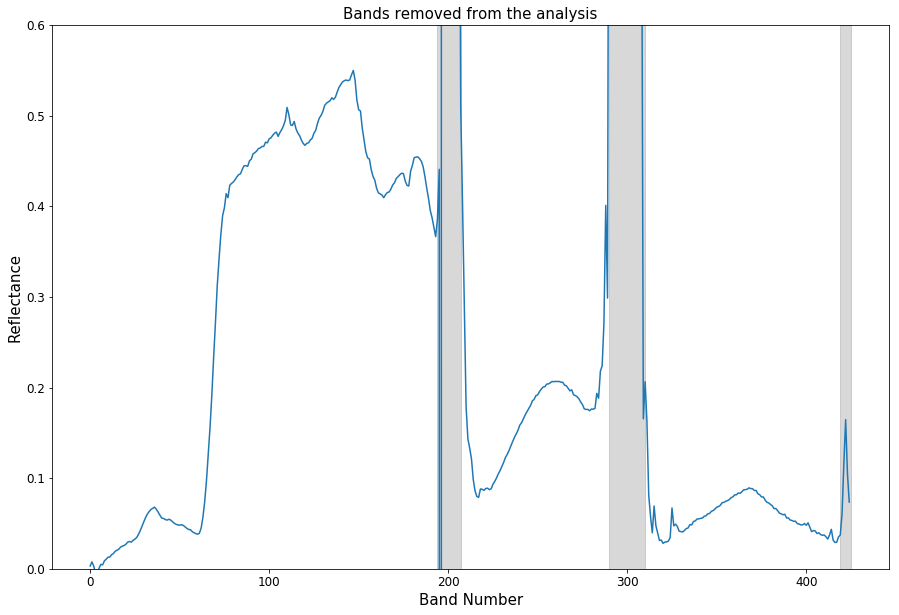

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("reflec_allwatersheds.csv", sep=',', header=0)

plt.subplots(figsize=(15,10))
plt.plot(np.arange(0,425),data.iloc[0,4:])
plt.ylim((0,0.6))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Band Number", fontsize=15)
plt.ylabel("Reflectance", fontsize=15)
plt.axvspan(194, 207, alpha=0.3, color='grey')
plt.axvspan(290, 310, alpha=0.3, color='grey')
plt.axvspan(419, 425, alpha=0.3, color='grey')
plt.title("Bands removed from the analysis", fontsize=15)
plt.savefig("bands_removed.png")

In [6]:
import pandas as pd
from osgeo import gdal
points = pd.read_csv("teller_coords", names=["Northing","Easting"], sep=" ")
print points.head()
img = gdal.Open("teller_watershed_all_bands")

        Northing       Easting
0  453815.219091  7.180776e+06
1  453820.319091  7.180776e+06
2  453825.419091  7.180776e+06
3  453830.519091  7.180776e+06
4  453815.219091  7.180771e+06
